# PROYECTO 3 - Security Data Science
### Parte 2

In [39]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from art.estimators.classification import KerasClassifier
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import ReverseSigmoid
from keras.preprocessing.image import ImageDataGenerator
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import TensorFlowV2Classifier
import joblib

In [2]:
# Escribir aqui el path de la carpeta con imagenes. Usar doble \\ para el path
path_root = "D:\\UVG\\9noSemestre\\SecurityDataScience\\Proyecto3---Security-DS\\malimg_dataset\\malimg_paper_dataset_imgs\\"

In [3]:
batches = ImageDataGenerator().flow_from_directory(directory = path_root, target_size = (64, 64), batch_size = 10000)

Found 9339 images belonging to 25 classes.


In [4]:
# Usamos next() para recorrer todos los elementos y generar un batch de imagenes y label del data set
imgs, labels = next(batches)

In [5]:
# nuestras imagenes estan en RGB con formato 64x64 [width x length x depth].
imgs.shape

(9339, 64, 64, 3)

# Entrenamiento y prueba
Se divide la data en 55% train y 45% test 

In [6]:
X_train, X_test0, y_train, y_test0 = train_test_split(imgs / 255., labels, test_size = 0.45)

In [7]:
X_train.shape

(5136, 64, 64, 3)

In [8]:
num_classes = 25 # se especifica la cantidad de clases de imagenes para clasificar

def malware_model_robust():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(1024, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [9]:
Malware_model = malware_model_robust() # se crea el modelo con capas mas densas, es decir un modelo mas pro para mejores resultados

In [10]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4335      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [11]:
y_train.shape

(5136, 25)

In [12]:
y_train_new = np.argmax(y_train, axis=1) # se extraen solo las clases
y_train_new

array([12, 16,  3, ...,  2,  2,  3], dtype=int64)

### Entrenamiento 

In [13]:
Malware_model.fit(X_train, y_train, validation_data=(X_test0, y_test0), epochs=10)

Epoch 1/10
161/161 [==============================] - 13s 76ms/step - loss: 1.2532 - accuracy: 0.6182 - val_loss: 0.4154 - val_accuracy: 0.8946
Epoch 2/10
161/161 [==============================] - 12s 73ms/step - loss: 0.3240 - accuracy: 0.9042 - val_loss: 0.2337 - val_accuracy: 0.9455
Epoch 3/10
161/161 [==============================] - 12s 73ms/step - loss: 0.1944 - accuracy: 0.9383 - val_loss: 0.1952 - val_accuracy: 0.9422
Epoch 4/10
161/161 [==============================] - 12s 73ms/step - loss: 0.1387 - accuracy: 0.9579 - val_loss: 0.1697 - val_accuracy: 0.9522
Epoch 5/10
161/161 [==============================] - 12s 73ms/step - loss: 0.1147 - accuracy: 0.9638 - val_loss: 0.1551 - val_accuracy: 0.9562
Epoch 6/10
161/161 [==============================] - 12s 73ms/step - loss: 0.0915 - accuracy: 0.9718 - val_loss: 0.1499 - val_accuracy: 0.9586
Epoch 7/10
161/161 [==============================] - 12s 73ms/step - loss: 0.0749 - accuracy: 0.9776 - val_loss: 0.1660 - val_accuracy:

In [14]:
# se guarda el modelo 
Malware_model.save('malware-listo-model-robust.h5')

In [15]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

In [16]:
# Recrea exactamente el mismo modelo cargando solo el archivo
malware_model = keras.models.load_model('malware-listo-model.h5')
# malware_model = keras.models.load_model('malware-listo-model-robust.h5')

In [17]:
classifier_original = KerasClassifier(malware_model, clip_values=(0, 1), use_logits=False)

### Predicciones

In [18]:
x_test_pred = np.argmax(classifier_original.predict(X_test0), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test0, axis=1))

print("Original test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_pred))

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Original test data (4203 images):
Correctly classified: 4080
Incorrectly classified: 123


Se puede ver segun los resultados que unicamente el 3.85% de los datos fueron seleccionados incorrectamente

In [19]:
attacker = FastGradientMethod(classifier_original, eps=0.5)
x_test_adv = attacker.generate(X_test0)

In [20]:
x_test_adv_pred = np.argmax(classifier_original.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))

print("Adversarial test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_adv_pred))

Adversarial test data (4203 images):
Correctly classified: 90
Incorrectly classified: 4113


Se puede ver segun los resultados que despues del ataque unicamente el 2.21% de los datos fueron seleccionados correctamente

In [21]:
# Recrea exactamente el mismo modelo cargando solo el archivo
malware_model_robust = keras.models.load_model('malware-listo-model-robust.h5')

In [22]:
classifier_robust = KerasClassifier(malware_model_robust, clip_values=(0, 1), use_logits=False)

In [23]:
attacks = BasicIterativeMethod(classifier_robust, eps=0.9, eps_step=0.01) # se especifica el ataque para robar info

### Se entrena el nuevo modelo 

In [24]:
trainer = AdversarialTrainer(classifier_robust, attacks, ratio=1.0)
trainer.fit(X_train, y_train, nb_epochs=15, batch_size=50)

Adversarial training epochs: 100%|██████████████████████████████████████████████████| 15/15 [3:52:30<00:00, 930.01s/it]


In [30]:
# se guarda el modelo 
model_malware_robust = trainer.get_classifier()

In [31]:
model_malware_robust.predict(X_test0)

array([[0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165],
       [0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165],
       [0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165],
       ...,
       [0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165],
       [0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165],
       [0.0110181 , 0.01115996, 0.35028887, ..., 0.03809001, 0.01090298,
        0.08138165]], dtype=float32)

In [32]:
x_test_robust_pred = np.argmax(model_malware_robust.predict(X_test0), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test0, axis=1))

print("Original test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_robust_pred))

Original test data (4203 images):
Correctly classified: 1329
Incorrectly classified: 2874


El nuevo modelo robusto responde mejor que el anterior a los ataques ya aproximadamente el 90% de los datos se clasificaron bien

In [33]:
attacker_robust = FastGradientMethod(model_malware_robust, eps=0.5)
x_test_adv_robust = attacker_robust.generate(X_test0)

In [34]:
x_test_adv_robust_pred = np.argmax(model_malware_robust.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))

print("Adversarial test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_adv_robust_pred))

Adversarial test data (4203 images):
Correctly classified: 1329
Incorrectly classified: 2874


El nuevo modelo robusto responde mejor que el anterior a los ataques ya aproximadamente el 90% de los datos se clasificaron bien

## Grafica ROC
para modelos utilizados y correcta clasificacion

In [35]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(X_test0)
    x_test_adv_robust = attacker_robust.generate(X_test0)
    
    x_test_adv_pred = np.argmax(classifier_original.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))]
    
    x_test_adv_robust_pred = np.argmax(model_malware_robust.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

In [36]:
nb_correct_original

[4080, 3898, 3118, 2549, 1907, 1412, 713, 155, 114, 103, 90, 59, 48, 47, 46]

In [37]:
nb_correct_robust

[1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329,
 1329]

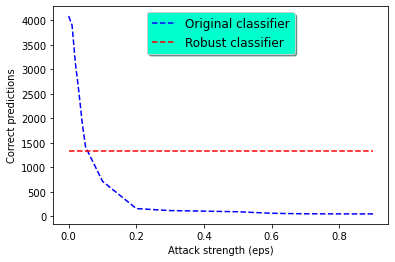

In [38]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

Con esta grafica se observa como el desempeño del clasificador original fue ligeramente mejor aunque la realidad es que son bastante similares 

In [40]:
joblib.dump(model_malware_robust,'model_malware_robust-parte2.h5')

['model_malware_robust-parte2.h5']